In [1]:
import data
import models
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets

In [2]:
# Load train set
train = dsets.MNIST('./', train=True, transform=None, target_transform=None, download=True)
imgs = train.data.reshape(-1, 784) / 255.0
labels = train.targets

# Shuffle and split into train and val
inds = torch.randperm(len(train))
imgs = imgs[inds]
labels = labels[inds]
val_x, val_y = imgs[:6000], labels[:6000]
train_x, train_y = imgs[6000:], labels[6000:]

# Load test set
test = dsets.MNIST('./', train=False, transform=None, target_transform=None, download=True)
test_x = test.data.reshape(-1, 784) / 255.0
test_y = test.targets

# Create TabularDatasets (which allow us to specify feature indices)
train_set = data.TabularDataset(train_x, train_y)
val_set = data.TabularDataset(val_x, val_y)
test_set = data.TabularDataset(test_x, test_y)
input_size = train_set.input_size
output_size = train_set.output_size

# Concrete mask

In [3]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_mask',
    k=20,
    input_size=input_size,
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').to(torch.device('cuda', 1))

# Train model
model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    start_temperature=10.0,
    end_temperature=0.01,
    loss_fn=nn.CrossEntropyLoss())

--------Epoch = 1--------
Train loss = 0.4131
Val loss = 0.4121
Max = 0.03, Mean = 0.03, Min = 0.03
--------Epoch = 2--------
Train loss = 0.3312
Val loss = 0.3383
Max = 0.03, Mean = 0.03, Min = 0.03
--------Epoch = 3--------
Train loss = 0.2945
Val loss = 0.3049
Max = 0.03, Mean = 0.03, Min = 0.03
--------Epoch = 4--------
Train loss = 0.2788
Val loss = 0.2959
Max = 0.03, Mean = 0.03, Min = 0.03
--------Epoch = 5--------
Train loss = 0.2750
Val loss = 0.2928
Max = 0.03, Mean = 0.03, Min = 0.03
--------Epoch = 6--------
Train loss = 0.2442
Val loss = 0.2642
Max = 0.04, Mean = 0.03, Min = 0.03
--------Epoch = 7--------
Train loss = 0.2468
Val loss = 0.2743
Max = 0.04, Mean = 0.03, Min = 0.03
--------Epoch = 8--------
Train loss = 0.2471
Val loss = 0.2765
Max = 0.04, Mean = 0.03, Min = 0.03
--------Epoch = 9--------
Train loss = 0.2071
Val loss = 0.2335
Max = 0.04, Mean = 0.03, Min = 0.03
--------Epoch = 10--------
Train loss = 0.2025
Val loss = 0.2252
Max = 0.04, Mean = 0.04, Min = 0.03

--------Epoch = 83--------
Train loss = 0.1999
Val loss = 0.2904
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 84--------
Train loss = 0.1978
Val loss = 0.2857
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 85--------
Train loss = 0.2030
Val loss = 0.3011
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 86--------
Train loss = 0.1894
Val loss = 0.2827
Max = 1.00, Mean = 1.00, Min = 1.00
--------Epoch = 87--------
Train loss = 0.1952
Val loss = 0.2933
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 88--------
Train loss = 0.1917
Val loss = 0.2867
Max = 1.00, Mean = 1.00, Min = 1.00
--------Epoch = 89--------
Train loss = 0.1909
Val loss = 0.2952
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 90--------
Train loss = 0.1854
Val loss = 0.2913
Max = 1.00, Mean = 1.00, Min = 0.98
--------Epoch = 91--------
Train loss = 0.1883
Val loss = 0.2946
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 92--------
Train loss = 0.1814
Val loss = 0.2949
Max = 1.00, Mean = 1.00, M

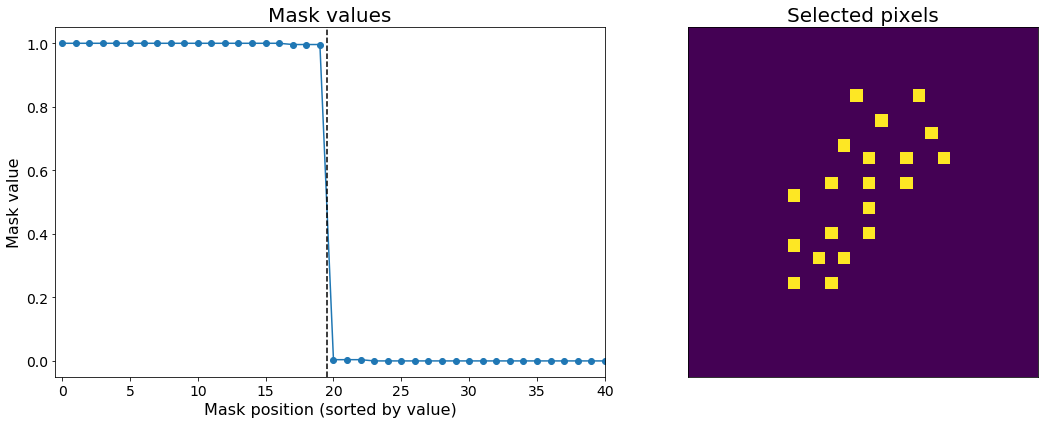

In [4]:
# Verify convergence
m = model.input_layer.sample(n_samples=256)
values = torch.mean(m, dim=0)
sorted_values = torch.sort(values, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
ax.plot(np.arange(input_size), sorted_values.cpu().data.numpy(), marker='o')
ax.axvline(model.input_layer.k - 0.5, color='black', linestyle='--')
ax.set_xlim(-0.5, 2 * model.input_layer.k)
ax.set_title('Mask values', fontsize=20)
ax.set_xlabel('Mask position (sorted by value)', fontsize=16)
ax.set_ylabel('Mask value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(values.cpu().data.numpy(), (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
# Extract select inds
inds = model.get_inds()

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').to(torch.device('cuda', 1))

model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.914


# Concrete selector

In [6]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_selector',
    k=20,
    input_size=input_size,
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').to(torch.device('cuda', 1))

# Train model
model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    start_temperature=10.0,
    end_temperature=0.01,
    loss_fn=nn.CrossEntropyLoss())

--------Epoch = 1--------
Train loss = 2.0562
Val loss = 2.0635
Max = 0.01, Mean = 0.00, Min = 0.00
--------Epoch = 2--------
Train loss = 2.0441
Val loss = 2.0500
Max = 0.01, Mean = 0.00, Min = 0.00
--------Epoch = 3--------
Train loss = 2.0146
Val loss = 2.0204
Max = 0.01, Mean = 0.01, Min = 0.00
--------Epoch = 4--------
Train loss = 1.4533
Val loss = 1.4466
Max = 0.02, Mean = 0.01, Min = 0.00
--------Epoch = 5--------
Train loss = 1.2109
Val loss = 1.2083
Max = 0.02, Mean = 0.01, Min = 0.00
--------Epoch = 6--------
Train loss = 0.9737
Val loss = 0.9669
Max = 0.03, Mean = 0.01, Min = 0.01
--------Epoch = 7--------
Train loss = 0.7610
Val loss = 0.7555
Max = 0.04, Mean = 0.02, Min = 0.01
--------Epoch = 8--------
Train loss = 0.6833
Val loss = 0.6789
Max = 0.04, Mean = 0.02, Min = 0.01
--------Epoch = 9--------
Train loss = 0.6080
Val loss = 0.6042
Max = 0.05, Mean = 0.02, Min = 0.01
--------Epoch = 10--------
Train loss = 0.6004
Val loss = 0.6021
Max = 0.05, Mean = 0.02, Min = 0.01

--------Epoch = 83--------
Train loss = 0.2365
Val loss = 0.3603
Max = 1.00, Mean = 1.00, Min = 0.98
--------Epoch = 84--------
Train loss = 0.2398
Val loss = 0.3655
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 85--------
Train loss = 0.2319
Val loss = 0.3631
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 86--------
Train loss = 0.2305
Val loss = 0.3599
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 87--------
Train loss = 0.2311
Val loss = 0.3592
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 88--------
Train loss = 0.2281
Val loss = 0.3611
Max = 1.00, Mean = 1.00, Min = 0.98
--------Epoch = 89--------
Train loss = 0.2256
Val loss = 0.3605
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 90--------
Train loss = 0.2220
Val loss = 0.3562
Max = 1.00, Mean = 1.00, Min = 1.00
--------Epoch = 91--------
Train loss = 0.2268
Val loss = 0.3688
Max = 1.00, Mean = 1.00, Min = 1.00
--------Epoch = 92--------
Train loss = 0.2210
Val loss = 0.3623
Max = 1.00, Mean = 1.00, M

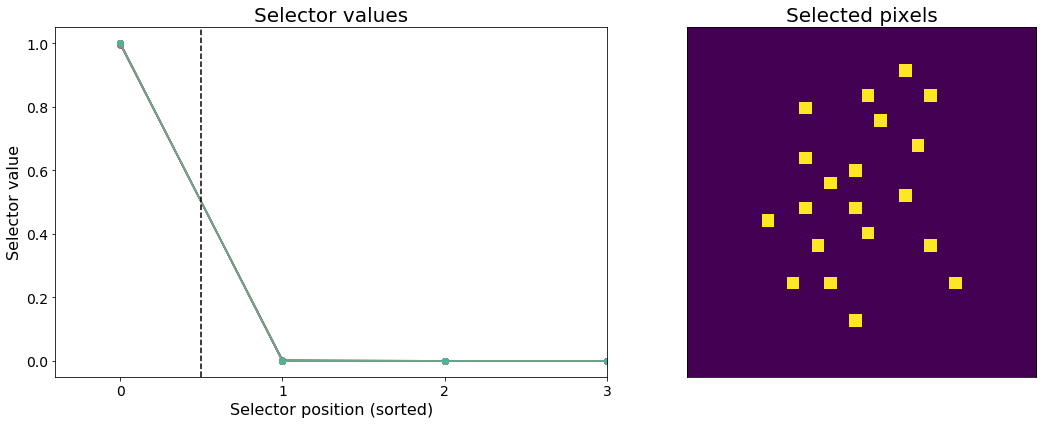

In [7]:
# Verify convergence
M = model.input_layer.sample(n_samples=256)
values = torch.mean(M, dim=0)
sorted_values = torch.sort(values, dim=1, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
for i in range(model.input_layer.k):
    ax.plot(np.arange(input_size), sorted_values[i].cpu().data.numpy(),
            marker='o', alpha=0.5)
ax.set_xlim(-0.4, 3)
ax.set_xticks(np.arange(4))
ax.axvline(0.5, color='black', linestyle='--')
ax.set_title('Selector values', fontsize=20)
ax.set_xlabel('Selector position (sorted)', fontsize=16)
ax.set_ylabel('Selector value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(torch.sum(values, dim=0).cpu().data.numpy(),
                     (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [8]:
# Extract select inds
inds = model.get_inds()

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').to(torch.device('cuda', 1))

model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.892


# Concrete gates

In [9]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_gates',
    input_size=input_size,
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').to(torch.device('cuda', 1))

# Train model
model.train(
    train_set,
    val_set,
    lam=0.005,
    lr=1e-3,
    mbsize=256,
    max_nepochs=1000,
    start_temperature=1.0,
    end_temperature=0.0001,
    loss_fn=nn.CrossEntropyLoss())

--------Epoch = 1--------
Train loss = 4.1060
Val loss = 4.1159
Mean dist = 0.04, Max dist = 0.06, Num sel = 784
--------Epoch = 2--------
Train loss = 3.9392
Val loss = 3.9504
Mean dist = 0.05, Max dist = 0.07, Num sel = 784
--------Epoch = 3--------
Train loss = 3.8680
Val loss = 3.8922
Mean dist = 0.06, Max dist = 0.08, Num sel = 784
--------Epoch = 4--------
Train loss = 3.8049
Val loss = 3.8222
Mean dist = 0.07, Max dist = 0.09, Num sel = 784
--------Epoch = 5--------
Train loss = 3.7417
Val loss = 3.7758
Mean dist = 0.08, Max dist = 0.11, Num sel = 784
--------Epoch = 6--------
Train loss = 3.6928
Val loss = 3.7249
Mean dist = 0.09, Max dist = 0.14, Num sel = 784
--------Epoch = 7--------
Train loss = 3.5917
Val loss = 3.6129
Mean dist = 0.11, Max dist = 0.15, Num sel = 784
--------Epoch = 8--------
Train loss = 3.5165
Val loss = 3.5502
Mean dist = 0.13, Max dist = 0.18, Num sel = 784
--------Epoch = 9--------
Train loss = 3.4014
Val loss = 3.4353
Mean dist = 0.15, Max dist = 0.2

--------Epoch = 74--------
Train loss = 0.3448
Val loss = 0.3859
Mean dist = 0.05, Max dist = 0.46, Num sel = 0
--------Epoch = 75--------
Train loss = 0.3471
Val loss = 0.3783
Mean dist = 0.05, Max dist = 0.45, Num sel = 0
--------Epoch = 76--------
Train loss = 0.3482
Val loss = 0.3688
Mean dist = 0.05, Max dist = 0.46, Num sel = 0
--------Epoch = 77--------
Train loss = 0.3511
Val loss = 0.3834
Mean dist = 0.05, Max dist = 0.47, Num sel = 0
--------Epoch = 78--------
Train loss = 0.3459
Val loss = 0.3743
Mean dist = 0.05, Max dist = 0.49, Num sel = 0
--------Epoch = 79--------
Train loss = 0.3502
Val loss = 0.3744
Mean dist = 0.05, Max dist = 0.44, Num sel = 0
--------Epoch = 80--------
Train loss = 0.3446
Val loss = 0.3742
Mean dist = 0.05, Max dist = 0.49, Num sel = 0
--------Epoch = 81--------
Train loss = 0.3513
Val loss = 0.3698
Mean dist = 0.05, Max dist = 0.45, Num sel = 0
--------Epoch = 82--------
Train loss = 0.3468
Val loss = 0.3744
Mean dist = 0.05, Max dist = 0.49, Num 

--------Epoch = 147--------
Train loss = 0.3223
Val loss = 0.3682
Mean dist = 0.04, Max dist = 0.49, Num sel = 16
--------Epoch = 148--------
Train loss = 0.3231
Val loss = 0.3743
Mean dist = 0.04, Max dist = 0.48, Num sel = 16
--------Epoch = 149--------
Train loss = 0.3234
Val loss = 0.3574
Mean dist = 0.04, Max dist = 0.50, Num sel = 15
--------Epoch = 150--------
Train loss = 0.3269
Val loss = 0.3690
Mean dist = 0.04, Max dist = 0.50, Num sel = 17
--------Epoch = 151--------
Train loss = 0.3231
Val loss = 0.3564
Mean dist = 0.04, Max dist = 0.49, Num sel = 15
--------Epoch = 152--------
Train loss = 0.3224
Val loss = 0.3722
Mean dist = 0.04, Max dist = 0.49, Num sel = 16
--------Epoch = 153--------
Train loss = 0.3208
Val loss = 0.3584
Mean dist = 0.04, Max dist = 0.49, Num sel = 16
--------Epoch = 154--------
Train loss = 0.3216
Val loss = 0.3666
Mean dist = 0.04, Max dist = 0.48, Num sel = 16
--------Epoch = 155--------
Train loss = 0.3197
Val loss = 0.3758
Mean dist = 0.04, Max 

--------Epoch = 219--------
Train loss = 0.2726
Val loss = 0.3518
Mean dist = 0.03, Max dist = 0.50, Num sel = 27
--------Epoch = 220--------
Train loss = 0.2734
Val loss = 0.3628
Mean dist = 0.03, Max dist = 0.48, Num sel = 26
--------Epoch = 221--------
Train loss = 0.2702
Val loss = 0.3570
Mean dist = 0.02, Max dist = 0.48, Num sel = 27
--------Epoch = 222--------
Train loss = 0.2740
Val loss = 0.3430
Mean dist = 0.02, Max dist = 0.46, Num sel = 27
--------Epoch = 223--------
Train loss = 0.2716
Val loss = 0.3519
Mean dist = 0.02, Max dist = 0.46, Num sel = 27
--------Epoch = 224--------
Train loss = 0.2669
Val loss = 0.3612
Mean dist = 0.02, Max dist = 0.43, Num sel = 27
--------Epoch = 225--------
Train loss = 0.2711
Val loss = 0.3433
Mean dist = 0.02, Max dist = 0.49, Num sel = 27
--------Epoch = 226--------
Train loss = 0.2702
Val loss = 0.3436
Mean dist = 0.02, Max dist = 0.43, Num sel = 27
--------Epoch = 227--------
Train loss = 0.2705
Val loss = 0.3442
Mean dist = 0.02, Max 

--------Epoch = 291--------
Train loss = 0.2182
Val loss = 0.3628
Mean dist = 0.01, Max dist = 0.50, Num sel = 27
--------Epoch = 292--------
Train loss = 0.2174
Val loss = 0.3607
Mean dist = 0.01, Max dist = 0.44, Num sel = 28
--------Epoch = 293--------
Train loss = 0.2155
Val loss = 0.3677
Mean dist = 0.01, Max dist = 0.44, Num sel = 28
--------Epoch = 294--------
Train loss = 0.2125
Val loss = 0.3725
Mean dist = 0.01, Max dist = 0.48, Num sel = 28
--------Epoch = 295--------
Train loss = 0.2174
Val loss = 0.3616
Mean dist = 0.01, Max dist = 0.43, Num sel = 28
--------Epoch = 296--------
Train loss = 0.2125
Val loss = 0.3673
Mean dist = 0.01, Max dist = 0.49, Num sel = 29
--------Epoch = 297--------
Train loss = 0.2143
Val loss = 0.3687
Mean dist = 0.01, Max dist = 0.47, Num sel = 28
--------Epoch = 298--------
Train loss = 0.2122
Val loss = 0.3680
Mean dist = 0.01, Max dist = 0.50, Num sel = 28
--------Epoch = 299--------
Train loss = 0.2157
Val loss = 0.3693
Mean dist = 0.01, Max 

--------Epoch = 363--------
Train loss = 0.1815
Val loss = 0.4248
Mean dist = 0.01, Max dist = 0.49, Num sel = 29
--------Epoch = 364--------
Train loss = 0.1794
Val loss = 0.4185
Mean dist = 0.01, Max dist = 0.50, Num sel = 29
--------Epoch = 365--------
Train loss = 0.1804
Val loss = 0.4226
Mean dist = 0.01, Max dist = 0.45, Num sel = 28
--------Epoch = 366--------
Train loss = 0.1775
Val loss = 0.4038
Mean dist = 0.01, Max dist = 0.50, Num sel = 27
--------Epoch = 367--------
Train loss = 0.1798
Val loss = 0.4391
Mean dist = 0.01, Max dist = 0.48, Num sel = 29
--------Epoch = 368--------
Train loss = 0.1791
Val loss = 0.4143
Mean dist = 0.01, Max dist = 0.50, Num sel = 27
--------Epoch = 369--------
Train loss = 0.1806
Val loss = 0.4090
Mean dist = 0.01, Max dist = 0.49, Num sel = 27
--------Epoch = 370--------
Train loss = 0.1760
Val loss = 0.4098
Mean dist = 0.01, Max dist = 0.46, Num sel = 28
--------Epoch = 371--------
Train loss = 0.1784
Val loss = 0.4195
Mean dist = 0.01, Max 

--------Epoch = 435--------
Train loss = 0.1609
Val loss = 0.4964
Mean dist = 0.00, Max dist = 0.42, Num sel = 27
--------Epoch = 436--------
Train loss = 0.1613
Val loss = 0.4822
Mean dist = 0.00, Max dist = 0.39, Num sel = 27
--------Epoch = 437--------
Train loss = 0.1621
Val loss = 0.4698
Mean dist = 0.00, Max dist = 0.40, Num sel = 27
--------Epoch = 438--------
Train loss = 0.1651
Val loss = 0.4738
Mean dist = 0.00, Max dist = 0.37, Num sel = 27
--------Epoch = 439--------
Train loss = 0.1602
Val loss = 0.4771
Mean dist = 0.00, Max dist = 0.37, Num sel = 27
--------Epoch = 440--------
Train loss = 0.1620
Val loss = 0.5015
Mean dist = 0.00, Max dist = 0.42, Num sel = 27
--------Epoch = 441--------
Train loss = 0.1629
Val loss = 0.4966
Mean dist = 0.00, Max dist = 0.43, Num sel = 27
--------Epoch = 442--------
Train loss = 0.1595
Val loss = 0.5153
Mean dist = 0.00, Max dist = 0.37, Num sel = 27
--------Epoch = 443--------
Train loss = 0.1608
Val loss = 0.4932
Mean dist = 0.00, Max 

--------Epoch = 507--------
Train loss = 0.1514
Val loss = 0.5693
Mean dist = 0.00, Max dist = 0.32, Num sel = 27
--------Epoch = 508--------
Train loss = 0.1499
Val loss = 0.5621
Mean dist = 0.00, Max dist = 0.38, Num sel = 27
--------Epoch = 509--------
Train loss = 0.1545
Val loss = 0.5840
Mean dist = 0.00, Max dist = 0.27, Num sel = 27
--------Epoch = 510--------
Train loss = 0.1509
Val loss = 0.5698
Mean dist = 0.00, Max dist = 0.26, Num sel = 27
--------Epoch = 511--------
Train loss = 0.1549
Val loss = 0.5852
Mean dist = 0.00, Max dist = 0.31, Num sel = 27
--------Epoch = 512--------
Train loss = 0.1531
Val loss = 0.5605
Mean dist = 0.00, Max dist = 0.33, Num sel = 27
--------Epoch = 513--------
Train loss = 0.1503
Val loss = 0.5674
Mean dist = 0.00, Max dist = 0.32, Num sel = 27
--------Epoch = 514--------
Train loss = 0.1488
Val loss = 0.5870
Mean dist = 0.00, Max dist = 0.31, Num sel = 27
--------Epoch = 515--------
Train loss = 0.1494
Val loss = 0.5557
Mean dist = 0.00, Max 

--------Epoch = 579--------
Train loss = 0.1472
Val loss = 0.6268
Mean dist = 0.00, Max dist = 0.18, Num sel = 27
--------Epoch = 580--------
Train loss = 0.1475
Val loss = 0.6505
Mean dist = 0.00, Max dist = 0.18, Num sel = 27
--------Epoch = 581--------
Train loss = 0.1489
Val loss = 0.6301
Mean dist = 0.00, Max dist = 0.12, Num sel = 27
--------Epoch = 582--------
Train loss = 0.1440
Val loss = 0.6395
Mean dist = 0.00, Max dist = 0.17, Num sel = 27
--------Epoch = 583--------
Train loss = 0.1458
Val loss = 0.6357
Mean dist = 0.00, Max dist = 0.16, Num sel = 27
--------Epoch = 584--------
Train loss = 0.1468
Val loss = 0.6422
Mean dist = 0.00, Max dist = 0.18, Num sel = 27
--------Epoch = 585--------
Train loss = 0.1473
Val loss = 0.6148
Mean dist = 0.00, Max dist = 0.16, Num sel = 27
--------Epoch = 586--------
Train loss = 0.1485
Val loss = 0.6354
Mean dist = 0.00, Max dist = 0.11, Num sel = 27
--------Epoch = 587--------
Train loss = 0.1501
Val loss = 0.6675
Mean dist = 0.00, Max 

--------Epoch = 651--------
Train loss = 0.1448
Val loss = 0.6926
Mean dist = 0.00, Max dist = 0.10, Num sel = 27
--------Epoch = 652--------
Train loss = 0.1455
Val loss = 0.6969
Mean dist = 0.00, Max dist = 0.11, Num sel = 27
--------Epoch = 653--------
Train loss = 0.1416
Val loss = 0.6738
Mean dist = 0.00, Max dist = 0.12, Num sel = 27
--------Epoch = 654--------
Train loss = 0.1455
Val loss = 0.7055
Mean dist = 0.00, Max dist = 0.10, Num sel = 27
--------Epoch = 655--------
Train loss = 0.1434
Val loss = 0.6614
Mean dist = 0.00, Max dist = 0.09, Num sel = 27
--------Epoch = 656--------
Train loss = 0.1436
Val loss = 0.6577
Mean dist = 0.00, Max dist = 0.11, Num sel = 27
--------Epoch = 657--------
Train loss = 0.1415
Val loss = 0.6408
Mean dist = 0.00, Max dist = 0.12, Num sel = 27
--------Epoch = 658--------
Train loss = 0.1436
Val loss = 0.6733
Mean dist = 0.00, Max dist = 0.12, Num sel = 27
--------Epoch = 659--------
Train loss = 0.1420
Val loss = 0.6673
Mean dist = 0.00, Max 

--------Epoch = 723--------
Train loss = 0.1428
Val loss = 0.7649
Mean dist = 0.00, Max dist = 0.11, Num sel = 27
--------Epoch = 724--------
Train loss = 0.1419
Val loss = 0.7623
Mean dist = 0.00, Max dist = 0.13, Num sel = 27
--------Epoch = 725--------
Train loss = 0.1432
Val loss = 0.7392
Mean dist = 0.00, Max dist = 0.13, Num sel = 27
--------Epoch = 726--------
Train loss = 0.1433
Val loss = 0.7164
Mean dist = 0.00, Max dist = 0.17, Num sel = 27
--------Epoch = 727--------
Train loss = 0.1438
Val loss = 0.7261
Mean dist = 0.00, Max dist = 0.12, Num sel = 27
--------Epoch = 728--------
Train loss = 0.1474
Val loss = 0.7559
Mean dist = 0.00, Max dist = 0.13, Num sel = 27
--------Epoch = 729--------
Train loss = 0.1465
Val loss = 0.7416
Mean dist = 0.00, Max dist = 0.13, Num sel = 27
--------Epoch = 730--------
Train loss = 0.1437
Val loss = 0.7349
Mean dist = 0.00, Max dist = 0.13, Num sel = 27
--------Epoch = 731--------
Train loss = 0.1421
Val loss = 0.7348
Mean dist = 0.00, Max 

--------Epoch = 795--------
Train loss = 0.1418
Val loss = 0.7235
Mean dist = 0.00, Max dist = 0.15, Num sel = 27
--------Epoch = 796--------
Train loss = 0.1423
Val loss = 0.7373
Mean dist = 0.00, Max dist = 0.16, Num sel = 27
--------Epoch = 797--------
Train loss = 0.1470
Val loss = 0.7093
Mean dist = 0.00, Max dist = 0.15, Num sel = 27
--------Epoch = 798--------
Train loss = 0.1447
Val loss = 0.7136
Mean dist = 0.00, Max dist = 0.18, Num sel = 27
--------Epoch = 799--------
Train loss = 0.1428
Val loss = 0.7332
Mean dist = 0.00, Max dist = 0.13, Num sel = 27
--------Epoch = 800--------
Train loss = 0.1438
Val loss = 0.7250
Mean dist = 0.00, Max dist = 0.18, Num sel = 27
--------Epoch = 801--------
Train loss = 0.1440
Val loss = 0.7196
Mean dist = 0.00, Max dist = 0.18, Num sel = 27
--------Epoch = 802--------
Train loss = 0.1419
Val loss = 0.7289
Mean dist = 0.00, Max dist = 0.13, Num sel = 27
--------Epoch = 803--------
Train loss = 0.1415
Val loss = 0.7341
Mean dist = 0.00, Max 

--------Epoch = 867--------
Train loss = 0.1451
Val loss = 0.7754
Mean dist = 0.00, Max dist = 0.19, Num sel = 27
--------Epoch = 868--------
Train loss = 0.1454
Val loss = 0.7730
Mean dist = 0.00, Max dist = 0.21, Num sel = 27
--------Epoch = 869--------
Train loss = 0.1426
Val loss = 0.7478
Mean dist = 0.00, Max dist = 0.26, Num sel = 27
--------Epoch = 870--------
Train loss = 0.1450
Val loss = 0.7868
Mean dist = 0.00, Max dist = 0.19, Num sel = 27
--------Epoch = 871--------
Train loss = 0.1435
Val loss = 0.7809
Mean dist = 0.00, Max dist = 0.26, Num sel = 27
--------Epoch = 872--------
Train loss = 0.1432
Val loss = 0.7336
Mean dist = 0.00, Max dist = 0.21, Num sel = 27
--------Epoch = 873--------
Train loss = 0.1413
Val loss = 0.7267
Mean dist = 0.00, Max dist = 0.27, Num sel = 27
--------Epoch = 874--------
Train loss = 0.1440
Val loss = 0.7618
Mean dist = 0.00, Max dist = 0.20, Num sel = 27
--------Epoch = 875--------
Train loss = 0.1482
Val loss = 0.7665
Mean dist = 0.00, Max 

--------Epoch = 939--------
Train loss = 0.1450
Val loss = 0.7470
Mean dist = 0.00, Max dist = 0.20, Num sel = 27
--------Epoch = 940--------
Train loss = 0.1451
Val loss = 0.7378
Mean dist = 0.00, Max dist = 0.23, Num sel = 27
--------Epoch = 941--------
Train loss = 0.1453
Val loss = 0.7427
Mean dist = 0.00, Max dist = 0.25, Num sel = 27
--------Epoch = 942--------
Train loss = 0.1456
Val loss = 0.7505
Mean dist = 0.00, Max dist = 0.27, Num sel = 27
--------Epoch = 943--------
Train loss = 0.1478
Val loss = 0.7198
Mean dist = 0.00, Max dist = 0.20, Num sel = 27
--------Epoch = 944--------
Train loss = 0.1429
Val loss = 0.7390
Mean dist = 0.00, Max dist = 0.21, Num sel = 27
--------Epoch = 945--------
Train loss = 0.1469
Val loss = 0.7549
Mean dist = 0.00, Max dist = 0.26, Num sel = 27
--------Epoch = 946--------
Train loss = 0.1458
Val loss = 0.7953
Mean dist = 0.00, Max dist = 0.26, Num sel = 27
--------Epoch = 947--------
Train loss = 0.1447
Val loss = 0.7326
Mean dist = 0.00, Max 

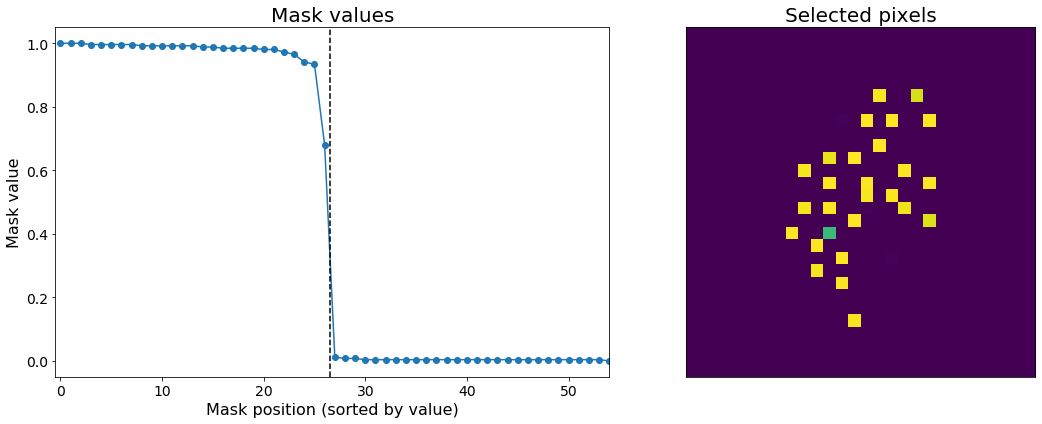

In [10]:
# Verify convergence
m = model.input_layer.sample(n_samples=256)
values = torch.mean(m, dim=0)
sorted_values = torch.sort(values, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
ax.plot(np.arange(input_size), sorted_values.cpu().data.numpy(),
        marker='o')
ind = (sorted_values < 0.5).nonzero()[0].item()
ax.axvline(ind - 0.5, color='black', linestyle='--')
ax.set_xlim(-0.5, min(input_size, 2 * ind))
ax.set_title('Mask values', fontsize=20)
ax.set_xlabel('Mask position (sorted by value)', fontsize=16)
ax.set_ylabel('Mask value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(values.cpu().data.numpy(), (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [11]:
# Extract selected inds
inds = model.get_inds(threshold=0.5)

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').to(torch.device('cuda', 1))

model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.936
